# RNN : many to one
### 워드 감정 분석
* many to one
* 다양한 입력 길이 처리하기 

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.sequence import pad_sequences  # 패딩 처리를 위해 사용 

%matplotlib inline

print(tf.__version__)

2.1.0


#### 데이터 셋 준비 
* 토큰으로 <pad>를 추가하여 워드를 캐릭터의 시퀀스로 생각했을 때 각각의 시퀀스의 길이가 다르기 때문에 배치 단위 연산을 위해 길이를 맞추기 위해 추가 
* 0 : <pad>로 처리하여 나중에 빈 부분은 0으로 처리하여 길이를 맞춤  

In [2]:
words = ['good', 'bad', 'worse', 'so good'] # 사용할 워드 
y_data = [1, 0, 0, 1] #정답(긍정/부정) 

# 토큰 덱셔너리 
char_set = ['<pad>'] + sorted(list(set(''.join(words))))
idx2char = {idx : char for idx, char in enumerate(char_set)}
char2idx = {char : idx for idx, char in enumerate(char_set)}

# 출력 
print(char_set)
print(idx2char)
print(char2idx)

['<pad>', ' ', 'a', 'b', 'd', 'e', 'g', 'o', 'r', 's', 'w']
{0: '<pad>', 1: ' ', 2: 'a', 3: 'b', 4: 'd', 5: 'e', 6: 'g', 7: 'o', 8: 'r', 9: 's', 10: 'w'}
{'<pad>': 0, ' ': 1, 'a': 2, 'b': 3, 'd': 4, 'e': 5, 'g': 6, 'o': 7, 'r': 8, 's': 9, 'w': 10}


#### 토큰 시퀀스를 인덱스 시퀀스로 변환

In [3]:
x_data = list(map(lambda word : [char2idx.get(char) for char in word], words))
x_data_len = list(map(lambda word : len(word), x_data))

print(x_data)
print(x_data_len)

[[6, 7, 7, 4], [3, 2, 4], [10, 7, 8, 9, 5], [9, 7, 1, 6, 7, 7, 4]]
[4, 3, 5, 7]


#### 정해진 시퀀스 크기로 만들어주기 
* 최대 길이는 10
* pad_sequences : 정해진 크기로 값을 채우거나 지우는 함수 

In [4]:
max_sequence = 10  
x_data = pad_sequences(sequences=x_data, maxlen=max_sequence, padding='post', truncating='post')

print(x_data)  # 입력 데이터 
print(x_data_len)  # 각 데이터의 길이 
print(y_data)  # 정답 레이블 

[[ 6  7  7  4  0  0  0  0  0  0]
 [ 3  2  4  0  0  0  0  0  0  0]
 [10  7  8  9  5  0  0  0  0  0]
 [ 9  7  1  6  7  7  4  0  0  0]]
[4, 3, 5, 7]
[1, 0, 0, 1]


#### 모델 만들기 
* many to one 구분을 위한 단순 rnn 모델
* np.eye : 정방단위행렬 반환 
* mask_zero=True : 전처리 단계에서 0으로된 부분을 알아서 처리함 
* trainable=False : 학습 하지 않음 

In [5]:
input_dim = len(char2idx)  # 입력 차수 
output_dim = len(char2idx)  # 출력 차수 
one_hot = np.eye(len(char2idx))  # 원-핫 인코딩 

hidden_size = 10  # 은닉층 10
num_classes = 2   # 결과 종류 2

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim, trainable=False, mask_zero=True, input_length=max_sequence,
                             embeddings_initializer=tf.keras.initializers.Constant(one_hot)),
    tf.keras.layers.SimpleRNN(units=hidden_size),
    tf.keras.layers.Dense(units=num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 11)            121       
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 10)                220       
_________________________________________________________________
dense (Dense)                (None, 2)                 22        
Total params: 363
Trainable params: 242
Non-trainable params: 121
_________________________________________________________________


#### 모델 최적화

In [6]:
def loss_fn(model, x, y):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=model(x), from_logits=True))

lr = 0.01
epochs = 30
batch_size = 2
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

In [7]:
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
tr_dataset = tr_dataset.shuffle(buffer_size = 4)
tr_dataset = tr_dataset.batch(batch_size=batch_size)

print(tr_dataset)

<BatchDataset shapes: ((None, 10), (None,)), types: (tf.int32, tf.int32)>


#### 모델 학습 

In [8]:
tr_loss_hist = []

for epoch in range(epochs):
    avg_loss = 0  # 손실 평균 
    tr_step = 0   # 학습 횟수
    
    for x_mb, y_mb in tr_dataset:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x=x_mb, y=y_mb)
        
        grads = tape.gradient(target=tr_loss, sources=model.variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_loss += tr_loss
        tr_step += 1
        
    else:
        avg_loss /= tr_step
        tr_loss_hist.append(avg_loss)
        
    if (epoch + 1) % 5 == 0:
        print('epoch : {:3}, tr_loss : {:.3f}'.format(epoch + 1, avg_loss.numpy()))    
            

epoch :   5, tr_loss : 0.093
epoch :  10, tr_loss : 0.016
epoch :  15, tr_loss : 0.006
epoch :  20, tr_loss : 0.004
epoch :  25, tr_loss : 0.003
epoch :  30, tr_loss : 0.002


#### 정확도 

In [9]:
yhat = model.predict(x_data)
yhat = np.argmax(yhat, axis=-1)
print('acc : {:.2%}'.format(np.mean(yhat == y_data)))

acc : 100.00%


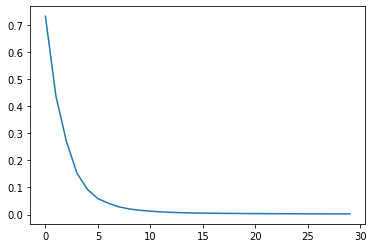

In [10]:
plt.plot(tr_loss_hist)